In [2]:
import cv2
import numpy as np
from utils import show_images

src = cv2.imread('./image/houghlines.png', -1)

<class 'numpy.ndarray'> (2643, 1, 4)


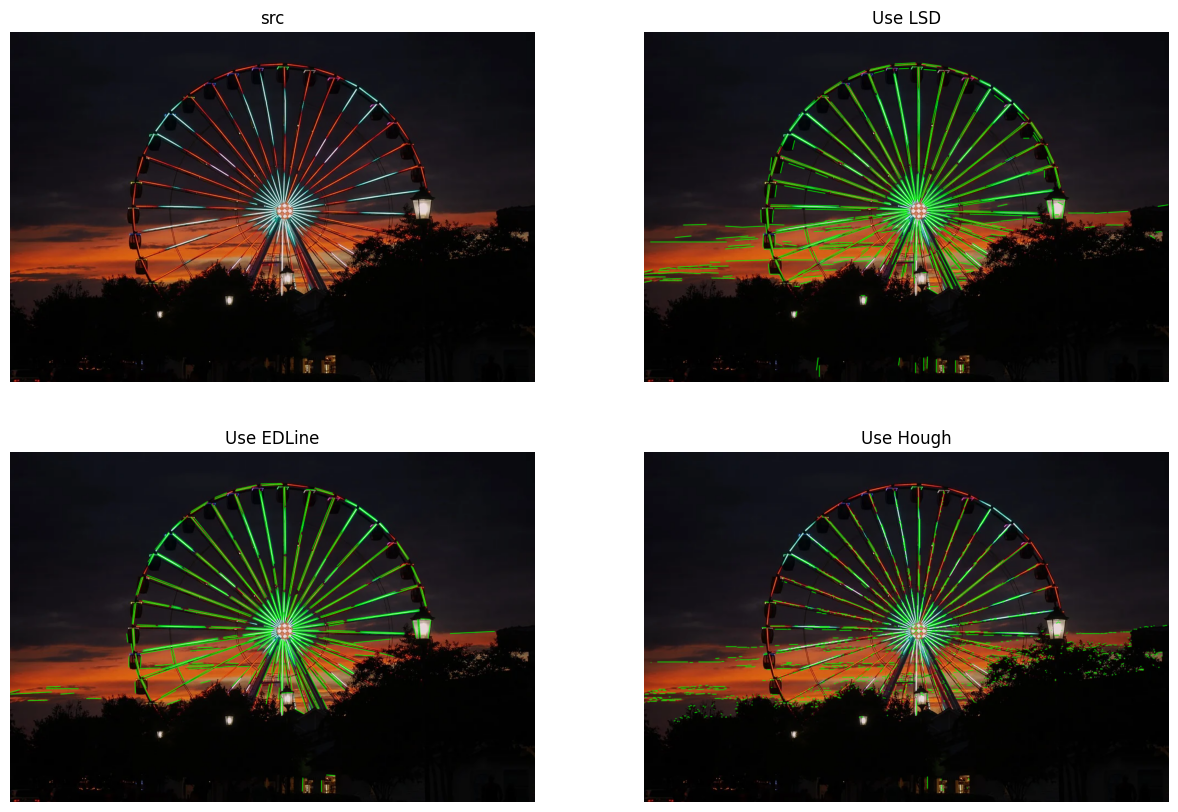

In [5]:
# 比较 Hough 和 LSD 和 EDLine

detector1 = cv2.line_descriptor.LSDDetector.createLSDDetector()

# keylines:tuple (keyline1, keyline2, keyline3, ....)
keylines1 = detector1.detect(src, scale=2, numOctaves=1)

out1 = np.copy(src)
for kl in keylines1:
    if kl.octave == 0:
        pt1, pt2 = kl.getStartPoint(), kl.getEndPoint()
        pt1 = (int(pt1[0]), int(pt1[1]))
        pt2 = (int(pt2[0]), int(pt2[1]))
        cv2.line(out1, pt1, pt2, (0, 255, 0), 1, cv2.LINE_AA)

detector2 = cv2.line_descriptor.BinaryDescriptor.createBinaryDescriptor()
keylines2 = detector2.detect(src)
out2 = np.copy(src)
for kl in keylines2:
    if kl.octave == 0:
        pt1, pt2 = kl.getStartPoint(), kl.getEndPoint()
        pt1 = (int(pt1[0]), int(pt1[1]))
        pt2 = (int(pt2[0]), int(pt2[1]))
        cv2.line(out2, pt1, pt2, (0, 255, 0), 1, cv2.LINE_AA)

# print('numofOctaves:', detector2.getNumOfOctaves())

# Hough 变换，需要传入边缘检测或阈值处理后的图片，返回值是 ndarray (n, 1, 4)
edge = cv2.Canny(src, 50, 150, apertureSize=3)
houghlines = cv2.HoughLinesP(edge, rho=1, theta=np.pi/180, threshold=100)
# print(type(houghlines), houghlines.shape)

out3 = np.copy(src)
for kl in houghlines:
    nowl = kl[0]
    cv2.line(out3, nowl[0:2], nowl[2:4], (0, 255, 0), 1, cv2.LINE_AA)


show_images([
    ('src', src),
    ('Use LSD', out1),
    ('Use EDLine', out2),
    ('Use Hough', out3)
], colnum=2, scale=10)

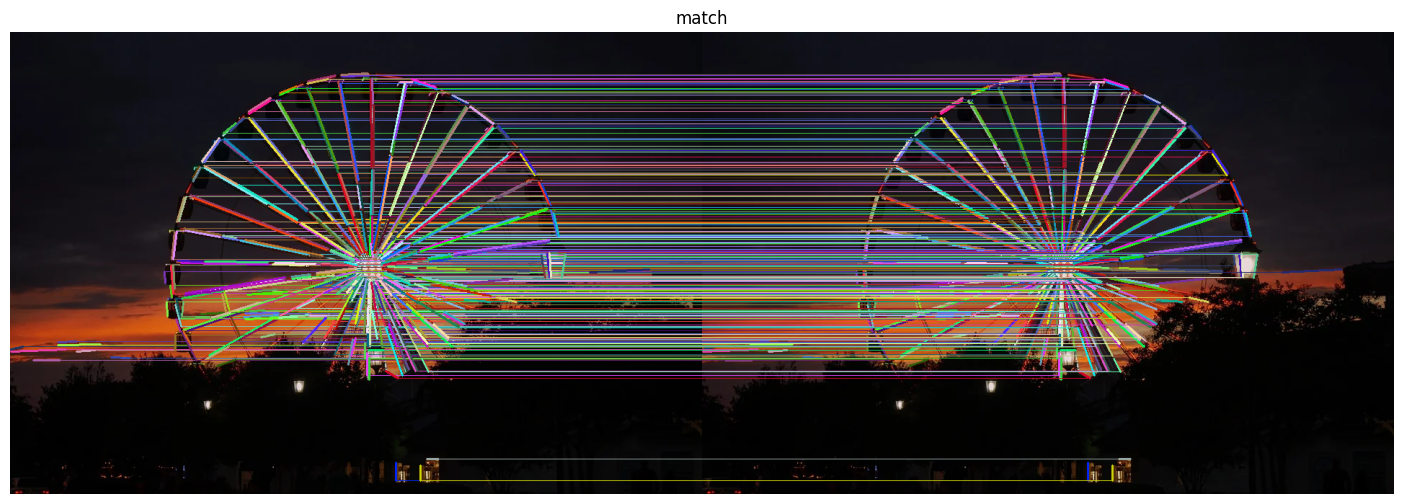

In [63]:
'''
完整的 检测直线 -> 描述直线 -> 匹配直线 流程
'''

# 只保留 octave 为 0 的直线
def get_octave_0(kls, dss):
    nkls, ndss = [], []
    for i, kl in enumerate(kls):
        if kl.octave == 0:
            nkls.append(kls[i])
            ndss.append(dss[i])
    return tuple(nkls), np.array(ndss)

detector = cv2.line_descriptor.BinaryDescriptor.createBinaryDescriptor()

keylines1 = detector.detect(src)
keylines1, descriptors1 = detector.compute(src, keylines1)
keylines1, descriptors1 = get_octave_0(keylines1, descriptors1)

# 不想找其他图片了，就重复对一张图片进行匹配吧...
src2 = np.copy(src)
keylines2 = detector.detect(src2)
keylines2, descriptors2 = detector.compute(src2, keylines2)
keylines2, descriptors2 = get_octave_0(keylines2, descriptors2)

# 匹配，有三种方法，但很遗憾 radiusMatch 没有 python 版本..
# BinaryDescriptorMacher，有些方法没有 python 版本，如 add 等，这个类本身继承自 DescriptorMatcher，和之前点的匹配基本差不多
MATCHES_DIST_THRESHOLD = 25
matcher = cv2.line_descriptor.BinaryDescriptorMatcher()
matches = matcher.match(descriptors1, descriptors2)
# matches = matcher.knnMatch(descriptors1, descriptors2, k=2)
# matches = matcher.radiusMatch(descriptors1, descriptors2, maxDistance=25)
matches = [m for m in matches if m.distance < MATCHES_DIST_THRESHOLD]

# 返回的时 DMatch，自行查阅相关方法
print(type(matches)) 

# 画图
matchimg1 = cv2.line_descriptor.drawLineMatches(
                img1=src, keylines1=keylines1,
                img2=src2, keylines2=keylines2,
                matches1to2=matches,
                # opencv python 版本的 bug，必须要添加 matchesMask(which matches must be drawn)，否则报 Unkown C++ error
                matchesMask=np.ones(len(matches), dtype=np.uint8)
            )

show_images([('match', matchimg1)])

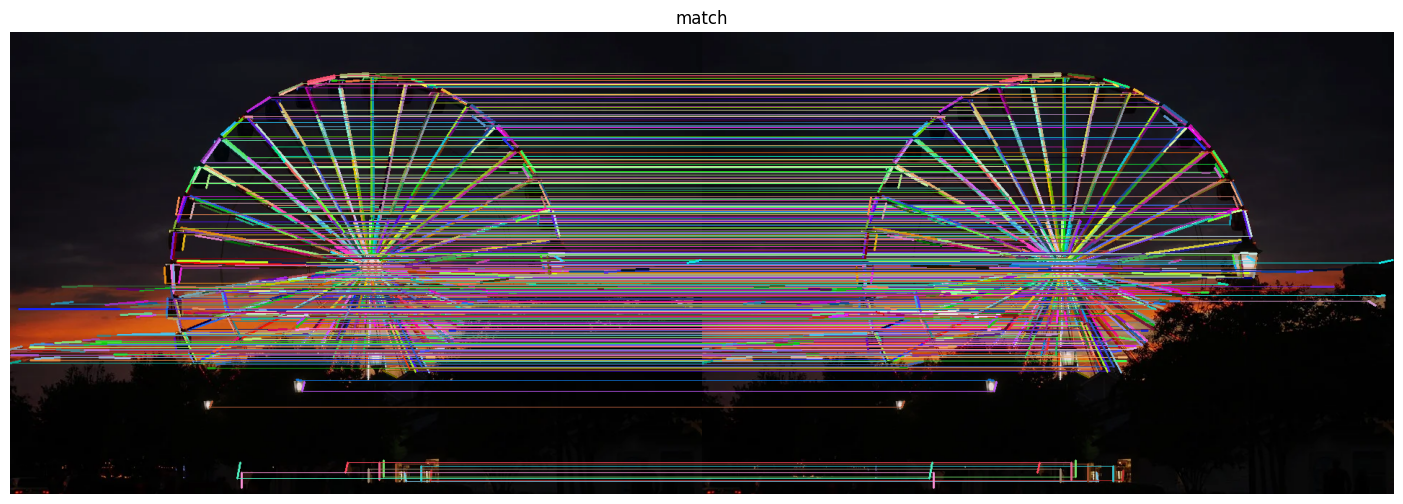

In [66]:
'''
检测直线 -> 描述直线 -> 匹配直线 流程，用 LSD 直线检测代替 EDLine(即 BinaryDescriptor)
'''

def get_octave_0(kls, dss):
    nkls, ndss = [], []
    for i, kl in enumerate(kls):
        if kl.octave == 0:
            nkls.append(kls[i])
            ndss.append(dss[i])
    return tuple(nkls), np.array(ndss)

# 这里用 LSD 检测
lsd_detector = cv2.line_descriptor.LSDDetector.createLSDDetector()
keylines1 = lsd_detector.detect(src, scale=2, numOctaves=1)
keylines2 = lsd_detector.detect(src, scale=2, numOctaves=1)

# LSD 只要检测直线，没有描述直线的功能，所以还是得用 BinaryDescriptor 中的描述方法
bd = cv2.line_descriptor.BinaryDescriptor.createBinaryDescriptor()
keylines1, descriptors1 = bd.compute(src, keylines1)
keylines2, descriptors2 = bd.compute(src2, keylines2)
keylines1, descriptors1 = get_octave_0(keylines1, descriptors1)
keylines2, descriptors2 = get_octave_0(keylines2, descriptors2)

# 匹配就还是老样子
MATCHES_DIST_THRESHOLD = 25
matcher = cv2.line_descriptor.BinaryDescriptorMatcher()
matches = matcher.match(descriptors1, descriptors2)
matches = [m for m in matches if m.distance < MATCHES_DIST_THRESHOLD]

# 画图
matchimg1 = cv2.line_descriptor.drawLineMatches(
                img1=src, keylines1=keylines1,
                img2=src, keylines2=keylines2,
                matches1to2=matches,
                matchesMask=np.ones(len(matches), dtype=np.uint8)
            )

show_images([('match', matchimg1)])